# N-BEATS
In this notebook, we show an example of how **N-BEATS** can be used with darts. If you are new to darts, we recommend you first follow the [quick start](https://unit8co.github.io/darts/quickstart/00-quickstart.html) notebook. 

**N-BEATS** is a state-of-the-art model that shows the potential of **pure DL architectures** in the context of the time-series forecasting. It outperforms well-established statistical approaches on the *M3*, and *M4* competitions. For more details on the model, see: https://arxiv.org/pdf/1905.10437.pdf.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts.timeseries import concatenate

In [3]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

## Daily energy generation example

We test NBEATS on a daily energy generation dataset from a Run-of-river power plant, as it exhibits various levels of seasonalities

Text(0.5, 1.0, 'Hourly generation hydro run-of-river and poundage')

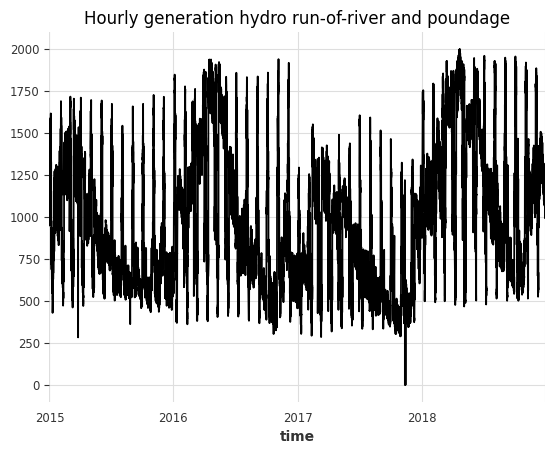

In [4]:
df = EnergyDataset().load().pd_dataframe()
df["generation hydro run-of-river and poundage"].plot()
plt.title("Hourly generation hydro run-of-river and poundage")

To simplify things, we work with the daily generation, and we fill the missing values present in the data by using the `MissingValuesFiller`:

Text(0.5, 1.0, 'Daily generation hydro run-of-river and poundage')

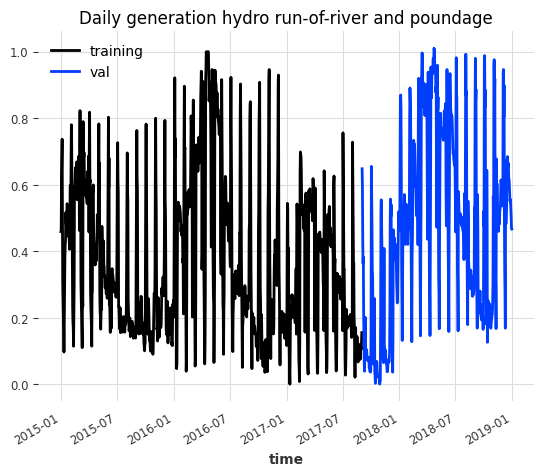

In [6]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = filler.transform(
    TimeSeries.from_dataframe(
        df_day_avg, "time", ["generation hydro run-of-river and poundage"]
    )
).astype(np.float32)

train, val = series.split_after(pd.Timestamp("20170901"))

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = concatenate([train_scaled, val_scaled])


train_scaled.plot(label="training")
val_scaled.plot(label="val")
plt.title("Daily generation hydro run-of-river and poundage")

We split the data into train and validation sets. Normally we would need to use an additional test set to validate the model on unseen data, but we will skip it for this example.

### Generic architecture

N-BEATS is a univariate model architecture that offers two configurations: a *generic* one and a *interpretable* one. The **generic architecture**  uses as little prior knowledge as possible, with no feature engineering, no scaling and no internal architectural components that may be considered time-series-specific. 

To start off, we use a model with the generic architecture of N-BEATS:

In [7]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [8]:
model_nbeats.fit(train, val_series=val, verbose=True)

[2021-12-18 15:49:42,951] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2021-12-18 15:49:42,951] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2021-12-18 15:49:43,028] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2021-12-18 15:49:43,028] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.


  0%|          | 0/100 [00:00<?, ?it/s]

Let's see the historical forecasts the model would have produced with an expanding training window, and a forecasting horizon of 7:

  0%|          | 0/97 [00:00<?, ?it/s]

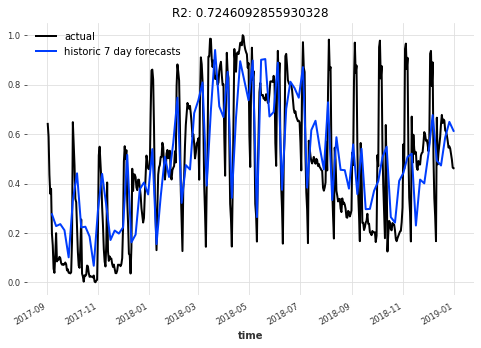

In [9]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=pd.Timestamp("20170901"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp("20170901"))

### Interpretable model

N-BEATS offers an *interpretable architecture* consisting of two stacks: A **trend** stack and a **seasonality** stack. The architecture is designed so that:

- The trend component is removed from the input  before it is fed into the seasonality stack 
- The **partial forecasts of trend and seasonality are available** as separate interpretable outputs

In [10]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_interpretable_run",
)

In [11]:
model_nbeats.fit(series=train_scaled, val_series=val_scaled, verbose=True)

[2021-12-18 15:51:18,696] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2021-12-18 15:51:18,696] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2021-12-18 15:51:18,714] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2021-12-18 15:51:18,714] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.


  0%|          | 0/100 [00:00<?, ?it/s]

Let's see the historical forecasts the model would have produced with an expanding training window, and a forecasting horizon of 7:

  0%|          | 0/97 [00:00<?, ?it/s]

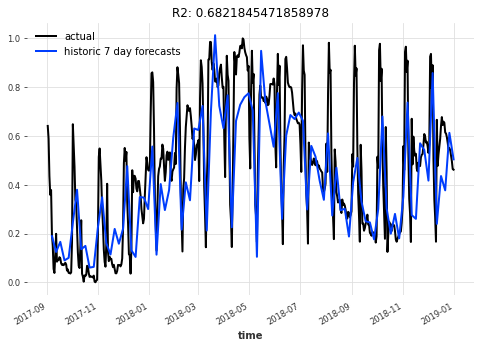

In [12]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=pd.Timestamp("20170901"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp("20170901"))